In [1]:
# This work was supported by the National Science Foundation under grant number CBET-1403403. 
import numpy as np
import scipy.constants   as const
import matplotlib.pyplot as plt
from   scipy.integrate import quad
import sympy as sp
%matplotlib inline

## Setup

In [7]:
R  = 1
Tw = 300
σ  = const.Stefan_Boltzmann
I0 = σ*Tw**4/np.pi

kConst  = 1
TgConst = 1500
IbConst = σ*TgConst**4/np.pi

## FVDOM

0.0641141357875 0.0641141357875468


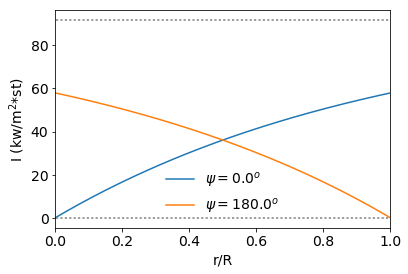

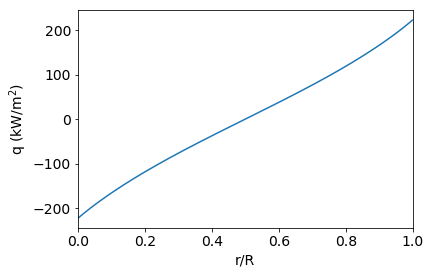

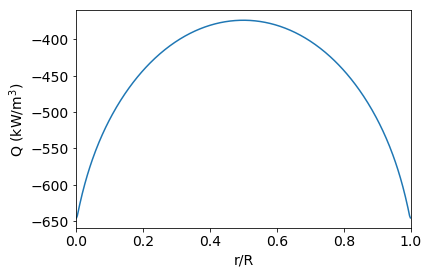

In [10]:
nr = 401  
nψ = 50   

######################################

rf = np.linspace(0,R,nr+1)
r  = 0.5*(rf[1:]+rf[:-1])
κ  = np.ones(nr) * kConst
ψ  = np.linspace(0,np.pi,nψ)
V  = np.ones(nr)
for k in range(nr):
    V[k] = rf[k+1] - rf[k]

dψ = ψ[1]-ψ[0]
dr = r[1]-r[0]

T    = np.ones(nr)*TgConst
Ib   = σ*T**4/np.pi
Iinf = σ*Tw**4/np.pi

I  = np.zeros((nr,nψ))
q  = np.zeros(nr)
Q  = np.zeros(nr)
α  = np.cos(ψ)

        
######################################

for i in range(0, int(nψ/2)):
    
    k = 0
    I[k,i] = ( V[k]*κ[k]*Ib[k] + α[i]*Iinf ) / ( α[i] + V[k]*κ[k] )
    
    for k in range(1,nr):
        I[k,i] = ( V[k]*κ[k]*Ib[k] + α[i]*I[k-1,i] ) / ( α[i] + V[k]*κ[k] )
        
for i in range(nψ-1, int(nψ/2)-1, -1):
    
    k = nr-1
    I[k,i] = ( V[k]*κ[k]*Ib[k] - α[i]*Iinf ) / (-α[i] + V[k]*κ[k] )
    
    for k in range(nr-2, -1, -1):
        I[k,i] = ( V[k]*κ[k]*Ib[k] - α[i]*I[k+1,i] ) / (-α[i] + V[k]*κ[k] )
    
######################################

q = np.zeros(nr)
for k in range(nr):
    for i in range(nψ):
        q[k] += 2*np.pi*dψ*I[k,i]*α[i]*np.sin(ψ[i])

Q = np.zeros(nr)
Q[0]    = -(q[1] -q[0])  /(r[1] -r[0])
Q[1:-1] = -(q[2:]-q[:-2])/(r[2:]-r[:-2])
Q[-1]   = -(q[-1]-q[-2]) /(r[-1]-r[-2])

######################################

i1 = 0
i2 = -1
plt.rc("font", size=14)
plt.plot(r/R,I[:,i1] /1000,'-')
plt.plot(r/R,I[:,i2]/1000,'-')
plt.plot(r/R,Ib/1000,                   ':', color='gray');
plt.plot(r/R,np.ones(len(r))*Iinf/1000, ':', color='gray');
plt.xlim([0,1])
plt.xlabel('r/R')
plt.ylabel(r'I (kw/m$^2$*st)')
plt.legend([r'$\psi=$'+'{:3.1f}'.format(ψ[i1]*180/np.pi)+r'$^o$', \
            r'$\psi=$'+'{:3.1f}'.format(ψ[i2]*180/np.pi)+r'$^o$'], frameon=False)

plt.figure()
plt.plot(r/R,q/1000)
plt.xlabel('r/R')
plt.ylabel(r'q (kW/m$^2$)')
plt.xlim([0,1])

plt.figure()
plt.plot(r/R,Q/1000)
plt.xlabel('r/R')
plt.ylabel(r'Q (kW/m$^3$)');
plt.xlim([0,1])

Qdom = Q.copy()
rdom = r.copy()

## Ray tracing, analytic solution

* Assumes constant $I_b$ and constant $k$

In [11]:
nr = 200
nψ = 50

dψ = np.pi/nψ
ψ  = np.linspace(dψ/2, np.pi-dψ/2, nψ)
r  = np.linspace(0,R,nr)
 
q  = np.zeros(nr)
I  = np.zeros((nr,nψ))

for ir in range(nr):
    for iψ in range(nψ):
        if ψ[iψ] < np.pi/2:
            s = r[ir]/np.cos(ψ[iψ])
        else:
            s = -(R-r[ir])/np.cos(ψ[iψ])
        I = IbConst - (IbConst-I0)*np.exp(-kConst*s) 
        q[ir] += 2*np.pi*I*np.cos(ψ[iψ])*np.sin(ψ[iψ])*dψ  

Q       = np.zeros(nr)
Q[0]    = -(q[1] -q[0])  /(r[1] -r[0])
Q[1:-1] = -(q[2:]-q[:-2])/(r[2:]-r[:-2])
Q[-1]   = -(q[-1]-q[-2]) /(r[-1]-r[-2])


QrayA = Q.copy()
rrayA = r.copy()


## Exact solution

* Assumes constant $I_b$ and constant $k$
* Integrate with quad

In [13]:
def get_Q(r):
    
    def fI_1(ψ):
        return -np.cos(ψ)*np.sin(ψ)*(Iinf-IbConst)*np.exp(-kConst*r/np.cos(ψ))*kConst/np.cos(ψ)
    def fI_2(ψ):
        return -np.cos(ψ)*np.sin(ψ)*(Iinf-IbConst)*np.exp(-kConst*(r-R)/np.cos(ψ))*kConst/np.cos(ψ)
               
    return -2*np.pi* ( quad(fI_1, 0, np.pi/2)[0] + quad(fI_2, np.pi/2, np.pi)[0] ) 

#---------------------------------

nr = 100
r  = np.linspace(0,R,nr)
Q  = np.zeros(len(r))
for i in range(nr):
    Q[i] = get_Q(r[i])

rexct = r.copy()
Qexct = Q.copy()

## Plot

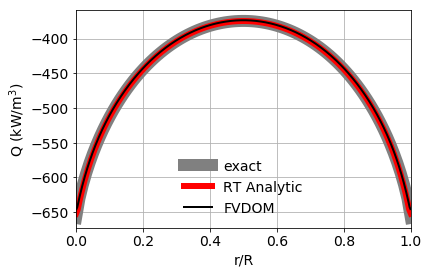

In [16]:
plt.rc('font', size=14)
plt.plot(rexct/R, Qexct/1000, color='gray', linewidth=12, label='exact') 
plt.plot(rrayA/R, QrayA/1000, color='red',  linewidth=6,  label='RT Analytic') 
plt.plot(rdom/R,  Qdom/1000,  color='black', linewidth=2,  label='FVDOM')
plt.xlabel("r/R")
plt.ylabel(r"Q (kW/m$^3$)")
plt.xlim([0,1])
plt.legend(frameon=False)
plt.grid();